#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose


from tqdm import tqdm

In [ ]:
df = pd.read_csv('/content/taxi.csv')
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = pd.read_csv('/content/taxi.csv', parse_dates=[0], index_col='datetime')

display(df.info())
display(df.describe())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.index.is_monotonic

<ipython-input-7-d1f11a250a74>:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic


True

<Axes: xlabel='datetime'>

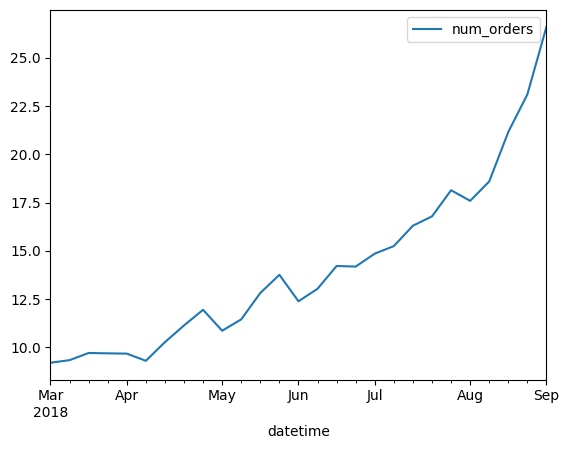

In [ ]:
df_plot = df.resample('1W').mean()
df_plot.plot()

Вырисовывается тренд, что с каждой неделей среднее количество заказов увеличивается в заданный период.Проверю его в следующем пункте.

### Обработка пропусков.

In [ ]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусков обнаружено не было.

### Обработка дубликатов.

In [ ]:
df.duplicated().sum()

26415

Дубликаты возможны, так как может быть одинаковое количество заказов.

### Небольшой выод по первому пункту

Изучил данные, обработал пропуски и дубликаты. Аномальных значений также выявлено не было.

## Анализ

In [ ]:
df_1H = df.resample('1H').sum()

In [ ]:
df_1D = df.resample('1D').sum()

### Тренд, Сезонность и Шум

In [ ]:
decomposed_df_1H = seasonal_decompose(df_1H)
decomposed_df_1D = seasonal_decompose(df_1D)
decomposed_df_1W = seasonal_decompose(df_1H['2018-03-01 00:00:00':'2018-03-07 00:00:00'])
decomposed_df_1M = seasonal_decompose(df_1D['2018-03-01 00:00:00':'2018-03-31 00:00:00'])

In [ ]:
def plt_plt(decomposed):
    plt.figure(figsize=(10,10))

    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')

    plt.tight_layout()

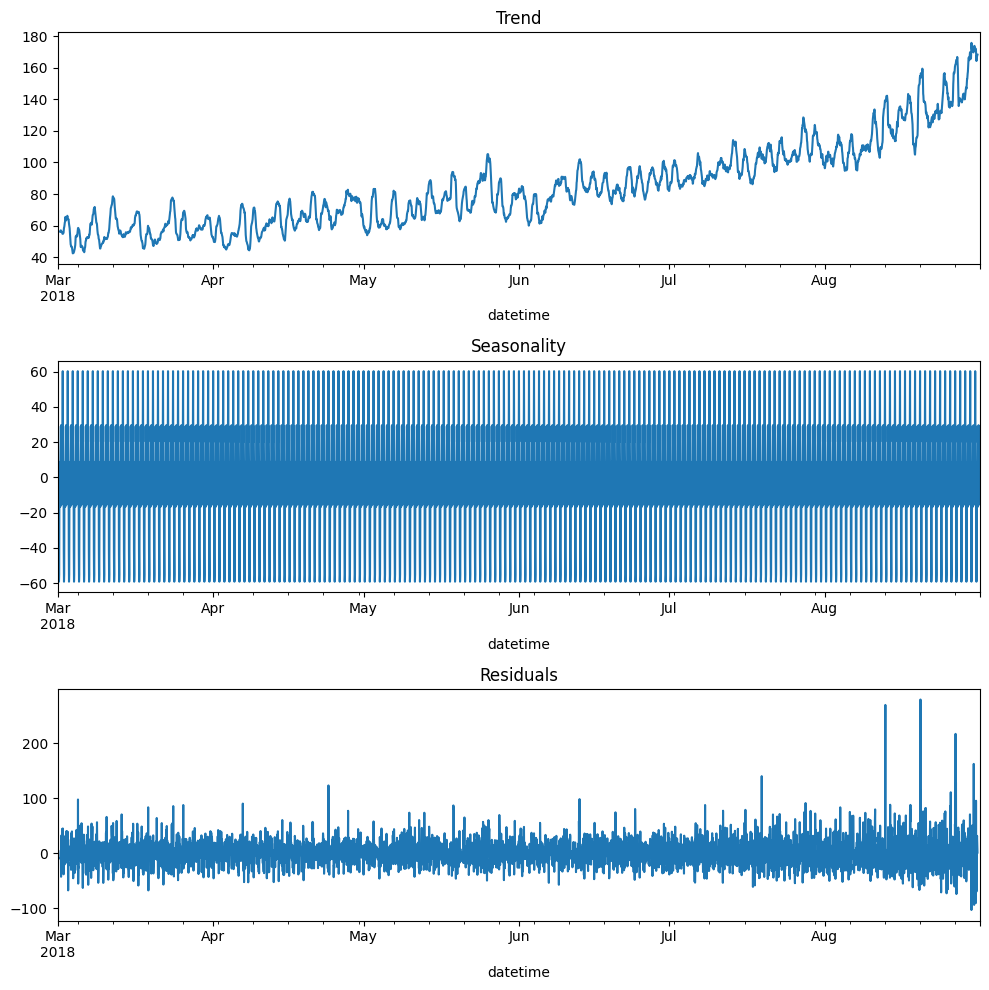

In [ ]:
plt_plt(decomposed_df_1H)

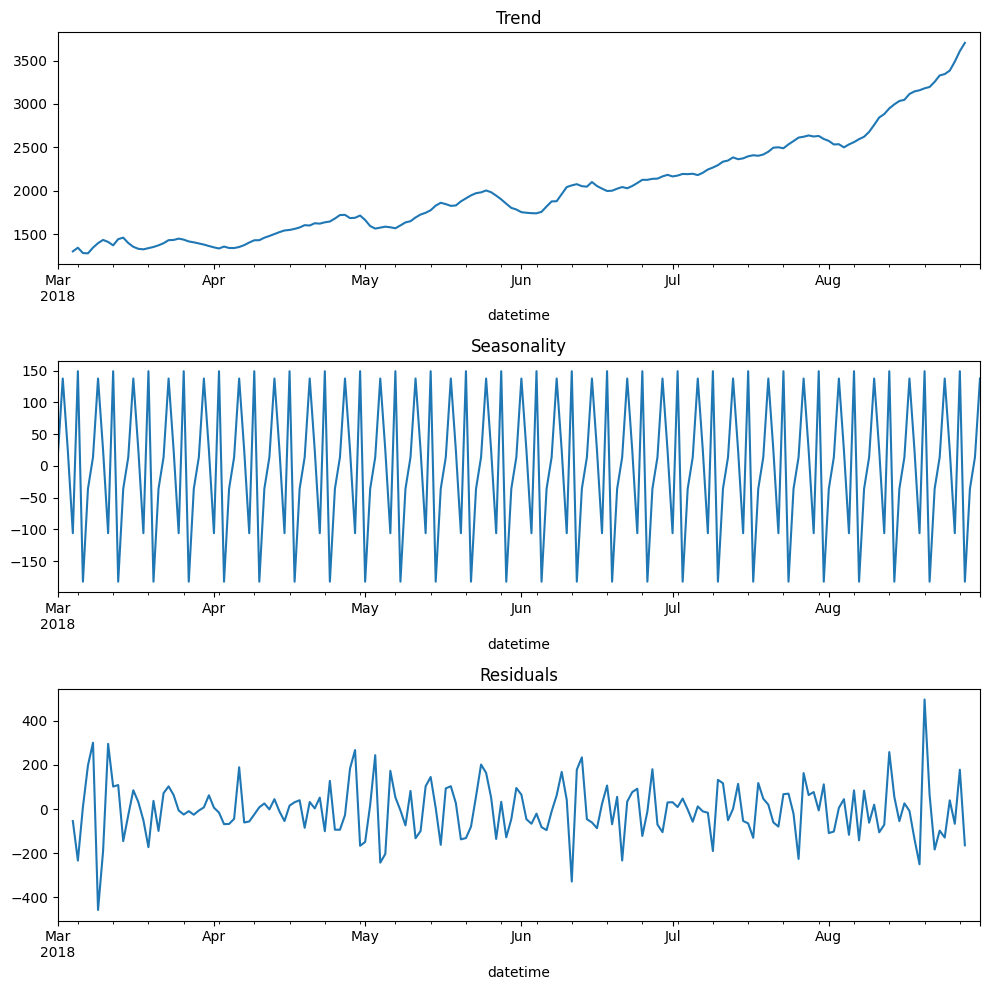

In [ ]:
plt_plt(decomposed_df_1D)

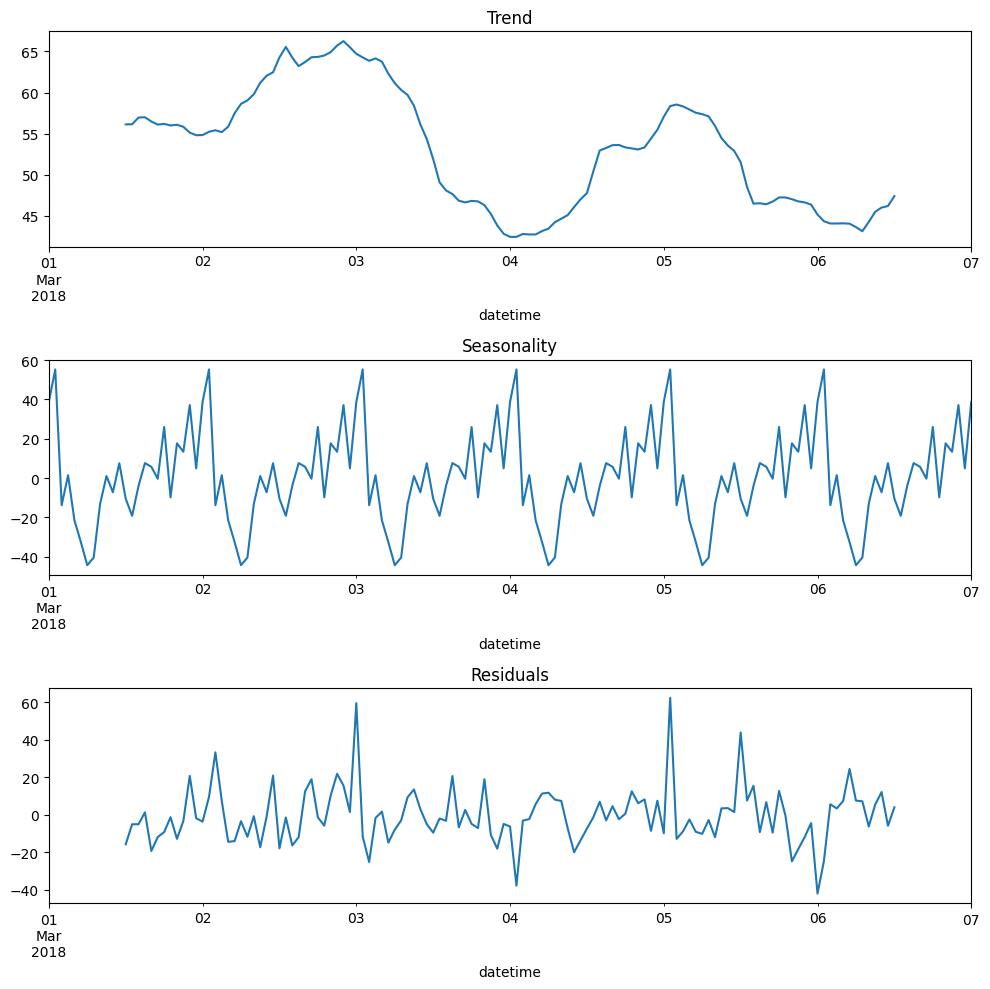

In [ ]:
plt_plt(decomposed_df_1W)

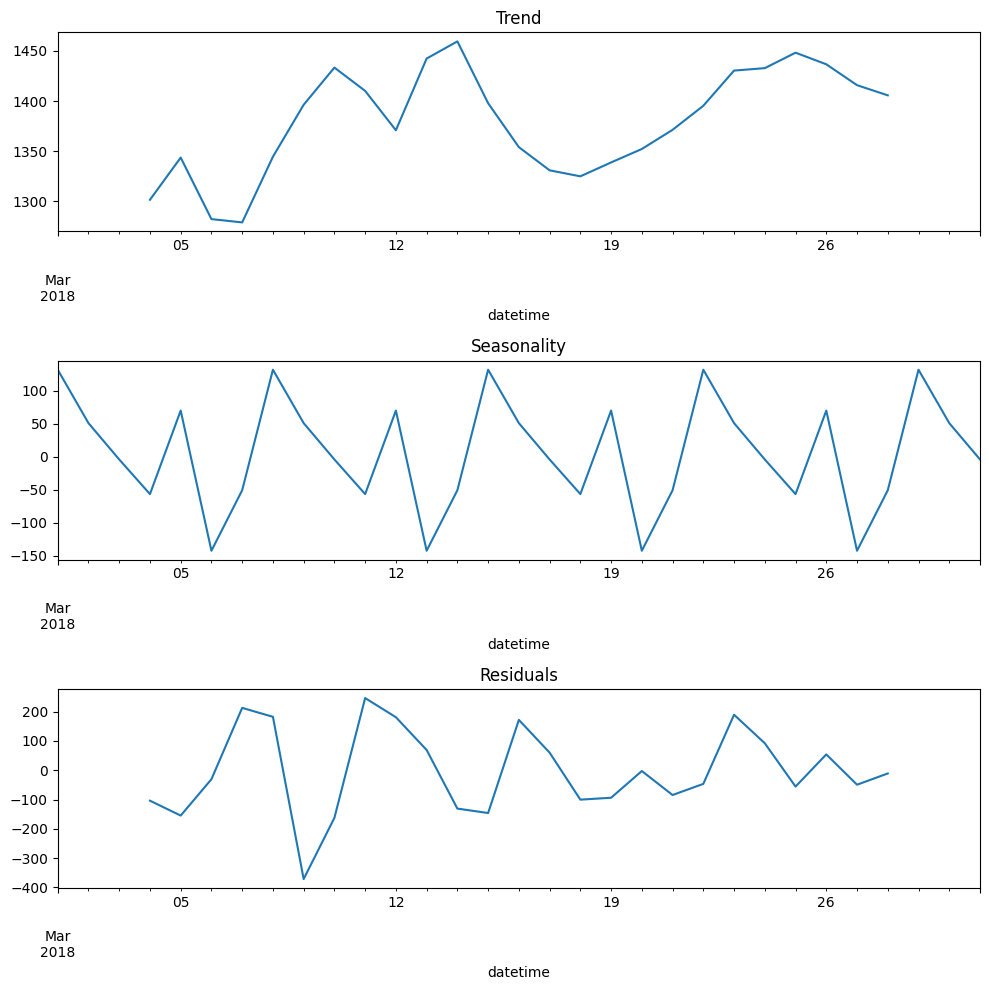

In [ ]:
plt_plt(decomposed_df_1M)

<Axes: xlabel='datetime'>

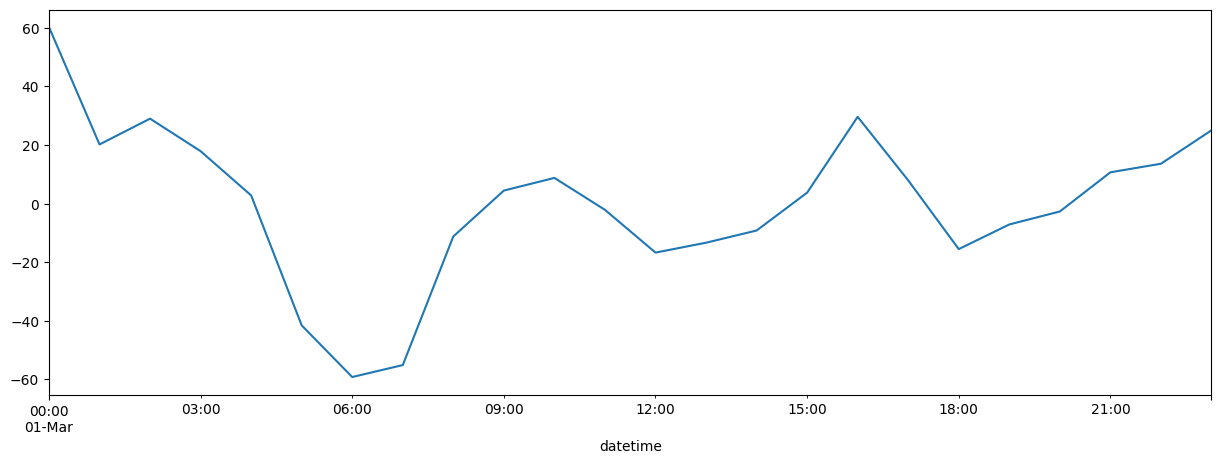

In [ ]:
decomposed_df_1H.seasonal['2018-03-01'].plot(figsize=(15, 5))

<Axes: xlabel='datetime'>

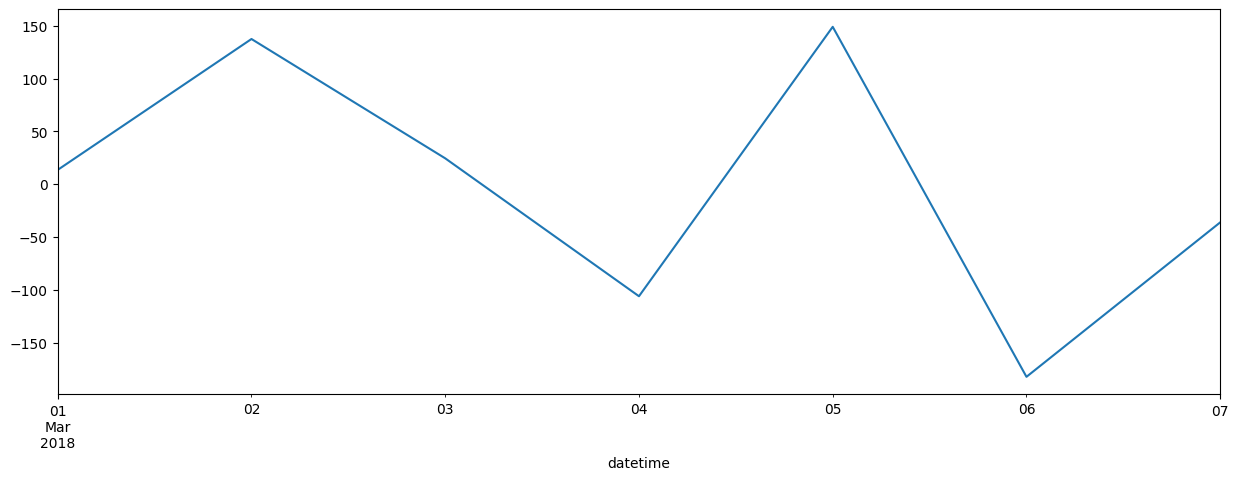

In [ ]:
decomposed_df_1D.seasonal['2018-03-01 00:00:00':'2018-03-07 00:00:00'].plot(figsize=(15, 5))

### Небольшой выод по второму пункту

Прослеживается тренд на увеличение количество поездок, непостоянный, со скачками. Самое большое количество поездок наблюдается в 12 ночи, также самый высокий пик поездок во вторник (5 марта 2018). С четверга на пятницу виднеется повышение количества поездок со снижением на выходные.  Это прослеживается на протяжении всего месяца.

## Обучение

### Создание признаков

In [ ]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

    return df

In [ ]:
df_last = make_features(df_1H, 168, 24)

<ipython-input-21-d4cd72930e7b>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
<ipython-input-21-d4cd72930e7b>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
<ipython-input-21-d4cd72930e7b>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

In [ ]:
valid_train, test = train_test_split(df_last, shuffle=False, test_size=0.1)
valid_train = valid_train.dropna()
train, valid = train_test_split(valid_train, shuffle=False, test_size=0.1)

train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']

valid_features = valid.drop(['num_orders'], axis=1)
valid_target = valid['num_orders']

test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

display(train_features.shape)
display(train_target.shape)

display(valid_features.shape)
display(valid_target.shape)

display(test_features.shape)
display(test_target.shape)

(3425, 171)

(3425,)

(381, 171)

(381,)

(442, 171)

(442,)

### CatBoost

In [ ]:
%%time

model_cat_boost = CatBoostRegressor(loss_function='RMSE', depth=10, iterations=201, random_state=2802)
model_cat_boost.fit(train_features, train_target, verbose=25)
predictions = model_cat_boost.predict(valid_features)

print('RMSE', sqrt(mean_squared_error(valid_target, predictions)))

Learning rate set to 0.183298
0:	learn: 32.9709063	total: 265ms	remaining: 52.9s
25:	learn: 14.7611617	total: 6.38s	remaining: 42.9s
50:	learn: 11.8604879	total: 11.7s	remaining: 34.3s
75:	learn: 9.5360520	total: 17.7s	remaining: 29.2s
100:	learn: 7.4589386	total: 23s	remaining: 22.8s
125:	learn: 5.7826478	total: 29.6s	remaining: 17.6s
150:	learn: 4.5035387	total: 35.2s	remaining: 11.7s
175:	learn: 3.5886897	total: 41.3s	remaining: 5.86s
200:	learn: 2.8158755	total: 46.6s	remaining: 0us
RMSE 29.862287681612575
CPU times: user 1min 22s, sys: 241 ms, total: 1min 23s
Wall time: 46.7 s


### LightGBM

In [ ]:
%%time

best_rmse = 1000000
n_estimators = 0
max_depth = 0
max_leaves = 0

for n_estimators in tqdm(range(1, 7, 2)):
    for max_depth in range(1, 7, 2):
        for max_leaves in range(1, 7, 2):
            model_lgbm = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, max_leaves=max_leaves)
            model_lgbm.fit(train_features, train_target)
            predictions = model_lgbm.predict(valid_features)
            rmse = sqrt(mean_squared_error(valid_target, predictions))
    if rmse < best_rmse:
        best_rmse = rmse
        best_n_estimators = n_estimators
        best_max_depth = max_depth
        best_max_leaves = max_leaves

print('Лучшее количество деревьев:', best_n_estimators)
print('Лучшая глубина деревьев:', best_max_depth)
print('Лучшее количество терминальных узлов:', best_max_leaves)
print('Лучший квадратный корень среднеквадратичной ошибки:', best_rmse)

  0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] num_leaves is set=31, max_leaves=1 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_leaves is set=31, max_leaves=1 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29744
[LightGBM] [Info] Number of data points in the train set: 3425, number of used features: 171
[LightGBM] [Info] Start training from score 75.936350
[LightGBM] [Warning] num_leaves is set=31, max_leaves=1 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_leaves is set=31, max_leaves=3 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_leaves is set=31, max_leaves=3 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005667 seconds.
You can set `force_col_wise=true` to

 33%|███▎      | 1/3 [00:00<00:01,  1.34it/s]

[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29744
[LightGBM] [Info] Number of data points in the train set: 3425, number of used features: 171
[LightGBM] [Info] Start training from score 75.936350
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_leaves is set=31, max_leaves=1 will be ignored. Current value: num_leaves=31
[LightGBM] [

 67%|██████▋   | 2/3 [00:01<00:00,  1.31it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] num_leaves is set=31, max_leaves=3 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29744
[LightGBM] [Info] Number of d

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Лучшее количество деревьев: 5
Лучшая глубина деревьев: 5
Лучшее количество терминальных узлов: 5
Лучший квадратный корень среднеквадратичной ошибки: 43.52569918600835
CPU times: user 2.34 s, sys: 33 ms, total: 2.37 s
Wall time: 2.35 s


In [ ]:
best_model_lightgbm = LGBMRegressor(n_estimators=5, max_depth=5, max_leaves=5)
best_model_lightgbm.fit(train_features, train_target)

[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_leaves is set=31, max_leaves=5 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29744
[LightGBM] [Info] Number of data points in the train set: 3425, number of used features: 171
[LightGBM] [Info] Start training from score 75.936350
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

LGBMRegressor(max_depth=5, max_leaves=5, n_estimators=5)

 ### LinearRegression

In [ ]:
%%time

model_lr = LinearRegression()
model_lr.fit(train_features, train_target)
predictions = model_lr.predict(valid_features)
print('RMSE', sqrt(mean_squared_error(valid_target, predictions)))

RMSE 28.117487441009793
CPU times: user 41 ms, sys: 17 ms, total: 58 ms
Wall time: 88.4 ms


### Небольшой вывод по третьему пункту

Лучший результат получил у линейной регрессии, также самое быстро время выполнения. Буду в дальнейшем исполшьзовать именно эту модель.

## Тестирование

In [ ]:
test_predictions = model_lr.predict(test_features)
print('RMSE', sqrt(mean_squared_error(test_target, test_predictions)))

RMSE 34.81292827240772


## Вывод ко всему проекту

В этом проекте я изучил данные, обработал пропуски и дубликаты, аномальных значений не выявил. Заметил, что прослеживается тренд на увеличение количество поездок и рост количества поездок от утра к вечеру каждый день. Получил отличное значение метрики RMSE на тестовой выборке, которое более, чем удовлетворяет заказчика.